In [1]:
import kagome, qiskit
import numpy as np
import matplotlib.pyplot as plt

startTime = kagome.strtime()
print(f"Start at {startTime}\n")
qVersion=kagome.init_notebook(output=True)

import qiskit.tools.jupyter
%qiskit_version_table

Start at Fri Feb 17 19:02:31 2023 UTC

qTools: myTools(major=1, minor=1, micro=0)
Qiskit: <dict>
    qiskit-terra : 0.22.4
    qiskit-aer : 0.11.2
    qiskit-ignis : 0.7.1
    qiskit-ibmq-provider : 0.19.2
    qiskit : 0.39.5
    qiskit-nature : 0.5.2
    qiskit-finance : 0.3.4
    qiskit-optimization : 0.4.0
    qiskit-machine-learning : None



In [2]:
# Setup Account, Provider, Service and Backends
from qiskit_ibm_runtime import (QiskitRuntimeService, Session,
                                Estimator as RuntimeEstimator)

provider, service = kagome.get_provider(channel='ibm_quantum',
                                        hub='ibm-q', group='open', project='main',
                                        output=True,   # Print out the available backends
                                       )

from qiskit.providers.fake_provider import FakeGuadalupe
guadalupeFake    = FakeGuadalupe()
simulator        = provider.get_backend('simulator_statevector')
nairobi          = provider.get_backend('ibm_nairobi')
oslo             = provider.get_backend('ibm_oslo')


Available backends
	ibmq_quito
	ibmq_lima
	ibmq_belem
	simulator_extended_stabilizer
	simulator_mps
	simulator_stabilizer
	ibmq_manila
	ibm_oslo
	ibmq_qasm_simulator
	simulator_statevector
	ibm_nairobi


In [3]:
from qiskit_aer import AerSimulator
nairobiSim   = AerSimulator.from_backend(nairobi)
guadalupeSim = AerSimulator.from_backend(FakeGuadalupe())

In [4]:
# Import Solution Utilities
import matplotlib.pyplot as plt
import numpy             as np
import rustworkx         as rx

from time import time
from heisenberg_model import HeisenbergModel

from qiskit import transpile, QuantumCircuit
from qiskit_nature.problems.second_quantization.lattice import Lattice
from qiskit_nature.mappers.second_quantization import LogarithmicMapper
from qiskit.circuit.library import EfficientSU2

plt.rcParams.update({"font.size": 16})  # enlarge matplotlib fonts

# Local Utilities

In [5]:
import statevector
import hamiltonians, ansatze
backends = {'7':nairobi,'16':FakeGuadalupe()}
#===================  Cell Structures ===================#
cells = hamiltonians.init_cells()
positions = hamiltonians.init_positions()

#====================  Hamiltonians =====================#
hams,eigenvalue_results,targets = hamiltonians.init_hamiltonians(cells=cells,force=False)
print("Hamiltonian Dimensions")
for key,value in hams.items():
    print(f"\t{key}:\t{value.primitive.dim}")
    
#=======================  Ansatze =======================#
Anzs = ansatze.init_ansatze(H=hams,backends=backends,targets=targets)
ansatze.list_Ansatz(Anzs)


H12_12: Edges 18 Eigenvalues 64 
	-18.0000:[2]
	-16.9613:[3]
	-16.9449:[6]
	-16.9296:[6]
	-16.8098:[3]
	-16.7353:[1]
	-16.7293:[2]
	-16.5674:[2]
	-16.3117:[3]
	-16.2754:[6]
	-16.2259:[1]
	-16.0412:[6]
	-15.6539:[3]
	-15.4601:[2]
	-15.3308:[3]
	-15.3178:[5]
	-15.1668:[10]

H12_16: Edges 18 Eigenvalues 64 
	-18.0000:[32]
	-16.9613:[25]
	-16.9449:[7]

H4_7: Edges 4 Eigenvalues 64 
	 -6.0000:[8]
	 -4.0000:[24]
	 -2.0000:[32]

H4_4: Edges 4 Eigenvalues 16 
	 -6.0000:[1]
	 -4.0000:[3]
	 -2.0000:[4]
	  2.0000:[3]
	  4.0000:[5]

H3_3: Edges 3 Eigenvalues 8 
	 -3.0000:[4]
	  3.0000:[4]

Hsq_4: Edges 4 Eigenvalues 16 
	 -8.0000:[1]
	 -4.0000:[3]
	 -0.0000:[7]
	  4.0000:[5]

Hsq_7: Edges 4 Eigenvalues 64 
	 -8.0000:[8]
	 -4.0000:[24]
	 -0.0000:[32]

H4_4_BC1: Edges 4 Eigenvalues 16 
	 -6.0000:[5]
	 -2.0000:[3]
	  2.0000:[3]
	  6.0000:[5]

H4_7_BC1: Edges 4 Eigenvalues 64 
	 -6.0000:[40]
	 -2.0000:[24]
Hamiltonian Dimensions
	12_12:	(4096, 4096)
	12_16:	(65536, 65536)
	4_7:	(128, 128)
	4_4:	(16, 

12_16
12_12
5_5
4_7
4_4
sq_4
sq_7
3_7
3_3
4_4_BC1
4_7_BC1


{'with_labels': True,
 'font_color': 'white',
 'node_color': 'purple',
 'pos': {0: [0.6, 5],
  1: [1.2, 3],
  2: [1.8, 5.1],
  3: [1.2, 0.9],
  4: [0.5, -1],
  5: [0.75, -1],
  6: [1.0, -1]}}

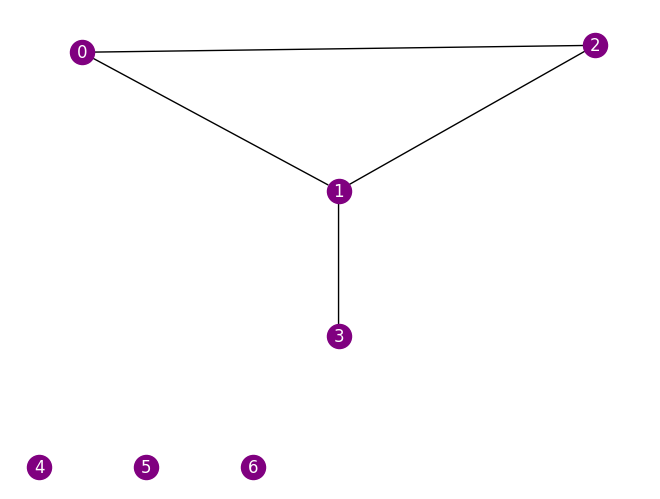

In [6]:
for key in cells:
    print(key)

kagome.draw_lattice(cells['4_7'],positions['4_7'])

# Sub-lattice
### Consider the lattice consisting of Nodes 0, 1, 2, and 3

* The full lattice can be built three (3) copies of this sub-lattice
* Nodes 0, 4, and 7, the starting corners of each sub-lattice
* Impose boundary conditions between 0 <-> 4 <-> 7 <-> 0
* Solve the energy level of the sub-lattice 0 thru 4 (5 nodes)
   * Use 4 nodes (0-3)
   * Boundary conditions to map H entries from 1<->4 and 3<->4

# Boundary Conditions

Node 4 is  related to Node 0 such that

$$
    \psi_4  =K*\psi_0  \\
    K^3 = I
$$

Assuming symetric rotations around the lattice we have

$$  
   K_i =R_x(\theta_i)*R_y(\phi_i)*R_z(\lambda_i) \\ i\in [0,1,2]  \\
   \sum_{i=0}^2\theta_i = n*2\pi \quad n \in I \\
   \sum_{i=0}^2\phi_i = n*2\pi  \\
   \sum_{i=0}^2\lambda_i = n*2\pi  \\
$$
 
Simple starting points are

$$  
\begin{equation}
(1) \quad \theta_i = \phi_i = \lambda_i = 0  \\
(2) \quad \theta_i = \phi_i = \lambda_i = \frac{2\pi}{3}  \\
(3) \quad \theta_i = \phi_i = \lambda_i = \frac{4\pi}{3}  \label{eq1} \\
\end{equation}
$$

For case 1:
$$
K=I  \\
\psi_4 = \psi_0
$$

# Adding Boundary Conditions
## Add Hamiltonian entries on the boundary
Must add $XX + YY + ZZ$ on virtual edges of the sub-lattice for to Node 4
$$\psi_1 \psi_4 = \psi_1\psi_0 + \psi_1 (K*\psi_0) \\
\psi_3 \psi_4 = \psi_3 (K\psi_0) $$
For case 1, $K=I$ the additional Hamiltonian entries are:

\begin{align}
H_{case1} =~~ &1.0*(IIZZ+IIYY+IIXX)~~ + \\ &1.0*(ZIIZ+YIIY+XIIX) 
\end{align}


# Data Runs
## Data Files, Ansatz and Optimizers

# --------------------- Solutions -----------------------------

In [7]:
def getX0(p_idx,curCache):
    if isinstance(p_idx,int) and (p_idx > 0) and (p_idx <= len(curCache)):
        x0 = curCache[p_idx]._callback_points[-1]
    elif isinstance(p_idx,str) and (p_idx == '0'):
        x0 = 0
    else:
        x0 = None
    return x0

# Optimizer Options

In [8]:
optimizers={}
from qiskit.algorithms.optimizers import SPSA
optimizers['01'] = {'opt': SPSA(maxiter=75), 'label':'SPSA(75)' }
optimizers['02'] = {'opt': SPSA(maxiter=75,callback=kagome.SPSA_callback), 
                    'label':'SPSA(75,cb)' }
optimizers['03'] = {'opt': SPSA(maxiter=75,callback=kagome.SPSA_callback,blocking=True),
                    'label':'SPSA(75,cb,block)' }
optimizers['04'] = {'opt': SPSA(maxiter=150,callback=kagome.SPSA_callback),
                    'label':'SPSA(150,cb)' }
optimizers['05'] = {'opt': SPSA(maxiter=150,callback=kagome.SPSA_callback,blocking=True),
                    'label':'SPSA(150,cb,block)' }
optimizers['06'] = {'opt': SPSA(maxiter=300,callback=kagome.SPSA_callback),
                    'label':'SPSA(300,cb)' }
optimizers['07'] = {'opt': SPSA(maxiter=300,callback=kagome.SPSA_callback,blocking=True),
                    'label':'SPSA(300,cb,block)' }
optimizers['08'] = {'opt': SPSA(maxiter=150,callback=kagome.SPSA_callback,trust_region=True),
                    'label':'SPSA(150,cb,trust)' }
optimizers['09'] = {'opt': SPSA(maxiter=300,callback=kagome.SPSA_callback,trust_region=True),
                    'label':'SPSA(300,cb,trust)' }
optimizers['10'] = {'opt': SPSA(maxiter=300,callback=kagome.SPSA_callback,second_order=True),
                    'label':'SPSA(300,cb,O(2)' }
optimizers['11'] = {'opt': SPSA(maxiter=100,callback=kagome.SPSA_callback),
                    'label':'SPSA(100,cb)' }
optimizers['12'] = {'opt': SPSA(maxiter=100,callback=kagome.SPSA_callback,trust_region=True),
                    'label':'SPSA(100,cb,trust)' }

In [ ]:
#================= Results cache and storage
fname    = 'test.dump'
curCache = kagome.load_results(fname)

#================= Problem Setup and Execution
Hkey = '4_4_BC1'
target = np.around(targets[Hkey],2)
Akey = 'A4_SU2_X2'   # A4_I6_L1  : A4_SU2_X0 : A4_SU2_X1
miniAnsatz = Anzs[Akey]   # Same as ansatz, no ancially qbits yet

#================= Runtime 
service = None # service # None  : service
backend = None # 'simulator_statevector' # None  : ibm_oslo  : simulator_statevector

nairobiSim   = AerSimulator(max_parallel_experiments=3).from_backend(nairobi)
guadalupeSim = AerSimulator(max_parallel_experiments=3).from_backend(FakeGuadalupe())
backend = guadalupeSim # nairobiSim   # aer-simulator if service is None
backendName = 'None' if backend is None else backend.name()
#================= Optimizer
# '04'->150,  '06'->300
Okey = '06'

#================= Starting Point
pt_idx = -1 # 'Random'       # i->Last point of curCache[i] '0'-> 0 vector; 'Random'->Start with random vector
x0 = getX0(pt_idx,curCache)  # ['0'] -> 0 vector; [int] -> initial point from cache; else -> Random
label = f"{backendName}\nH:{Hkey} A:{Anzs[Akey].name} \nOpt:{optimizers[Okey]['label']} x0={pt_idx}"

if 1:
    custom_vqe = kagome.run_kagomeVQE(hams[Hkey], Anzs[Akey], optimizers[Okey]['opt'], 
                                 miniAnsatz=miniAnsatz,
                                 timeout=None, x0=x0, target=target,
                                 service=service, backend=backend,
                                 resultsList=curCache,
                                 label=label )
    kagome.save_results(curCache,fname)
else: 
    print(label)

Loaded 9 results from test.dump
aer_simulator(fake_guadalupe)
H:4_4_BC1 A:|1010> A4_SU2_X2 
Opt:SPSA(300,cb) x0=-1 idx=9


Skipping iteration 44 with step=0.0
Skipping iteration 108 with step=0.0
Skipping iteration 184 with step=0.0
Convergence Failure
Duration 4 min, 58 sec Iterations=300 Accepted=100.0 % Rejected=0 min at n=272
Ground State: Computed -5.097656 Min -5.175781 Expected -6.0
15.039062 % Error


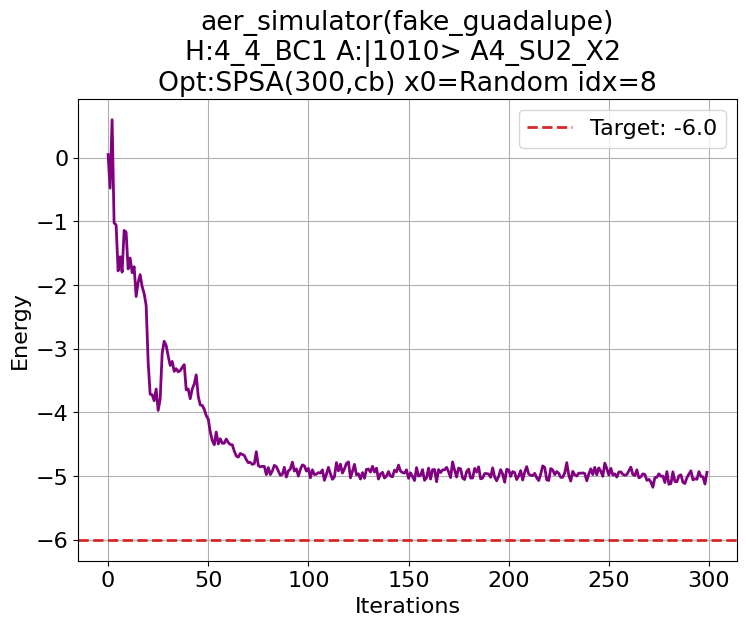

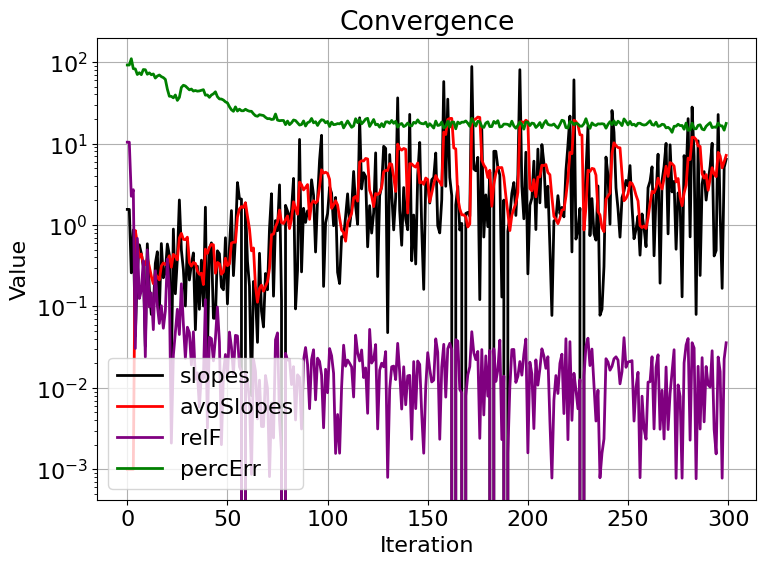

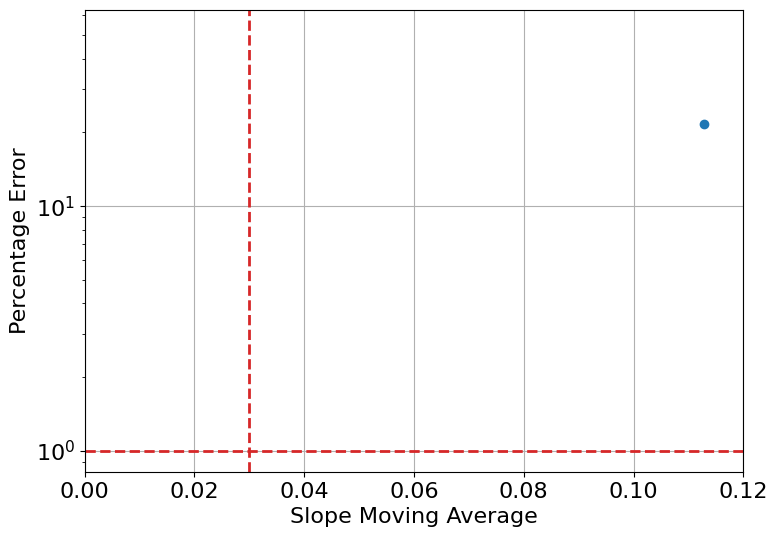

In [45]:
kagome.plot_SPSA_convergence(curCache,
                             indices=[-1],
                             conv_lim = 0.03,
                             movingAvg=5,
                             perc=6,
                             minStart=20)

In [11]:
# idx = -1
# curResult = curCache[idx]

# plot_bloch_multivector(VQE2MiniSvector(curResult))
# displayNormedData(curResult,nqubits=4)

# Svector_normed,_= getNormedState(curResult)
# coords=getCoords(Svector_normed)
# for q_coords in coords:
#     print(np.real(q_coords))

# Additional Python Code to Include

In [15]:
from qiskit.primitives import BackendEstimator
backendNairobi = BackendEstimator(nairobiSim, skip_transpilation=False)

In [ ]:
kagome.list_results(curCache)

In [28]:
import importlib
import jTools
importlib.reload(hamiltonians)
importlib.reload(ansatze)
importlib.reload(kagome)
jTools.cellOutputAll()

<module 'hamiltonians' from '/home/richard/src/qiskit-notebooks/Qiskit-Challenges/open-science-prize-2022/hamiltonians.py'>

<module 'ansatze' from '/home/richard/src/qiskit-notebooks/Qiskit-Challenges/open-science-prize-2022/ansatze.py'>

<module 'kagome' from '/home/richard/src/qiskit-notebooks/Qiskit-Challenges/open-science-prize-2022/kagome.py'>